#Transfer Learning for Computer Vision (Tutorial and Exercices)


This is a modified version of PyTorch tutorial:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

* License: BSD
* Author of original tutorial: Sasank Chilamkurthy https://chsasank.github.io
* Adapated and extended for teaching purpose by [Bruno Galerne](https://www.idpoisson.fr/galerne)


## Check that the colab has a GPU:
(otherwise go to Eit->Notebook properties ->...)

In [ ]:
!nvidia-smi

Wed Feb  1 13:08:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
!wget 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
!unzip -nq hymenoptera_data.zip
!ls
!ls hymenoptera_data
!ls hymenoptera_data/train/


--2023-02-01 08:24:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.250.7, 13.224.250.113, 13.224.250.5, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   204MB/s    in 0.2s    

2023-02-01 08:24:42 (204 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

hymenoptera_data  hymenoptera_data.zip	sample_data
train  val
ants  bees


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([ #data augmentation
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #moyenne qui est plus sombre et on divise chaque canal par un ecart type sinon il y'aura des images plus sombre que d'autres
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), #besoin d'une image carré
        transforms.CenterCrop(224),
        transforms.ToTensor(), #conversion en tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #on normalise
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)

              for x in ['train', 'val']}
#ne modifie pas l'image de base et crée des variantes de cet image

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('Class names are: ', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Class names are:  ['ants', 'bees']


## Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



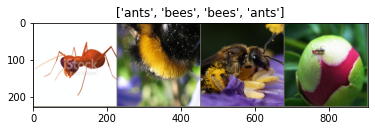

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the pretrained convnet

Load a pretrained model and reset final fully connected layer.

Here we use **ResNet18**.

The original architecture of which is designed for the classification of 1000 ImageNet classes. The architecture is a 18-layer version of the one above (from the original paper: https://arxiv.org/pdf/1512.03385.pdf[texte du lien](https:// [texte du lien](https:// [texte du lien](https://))))



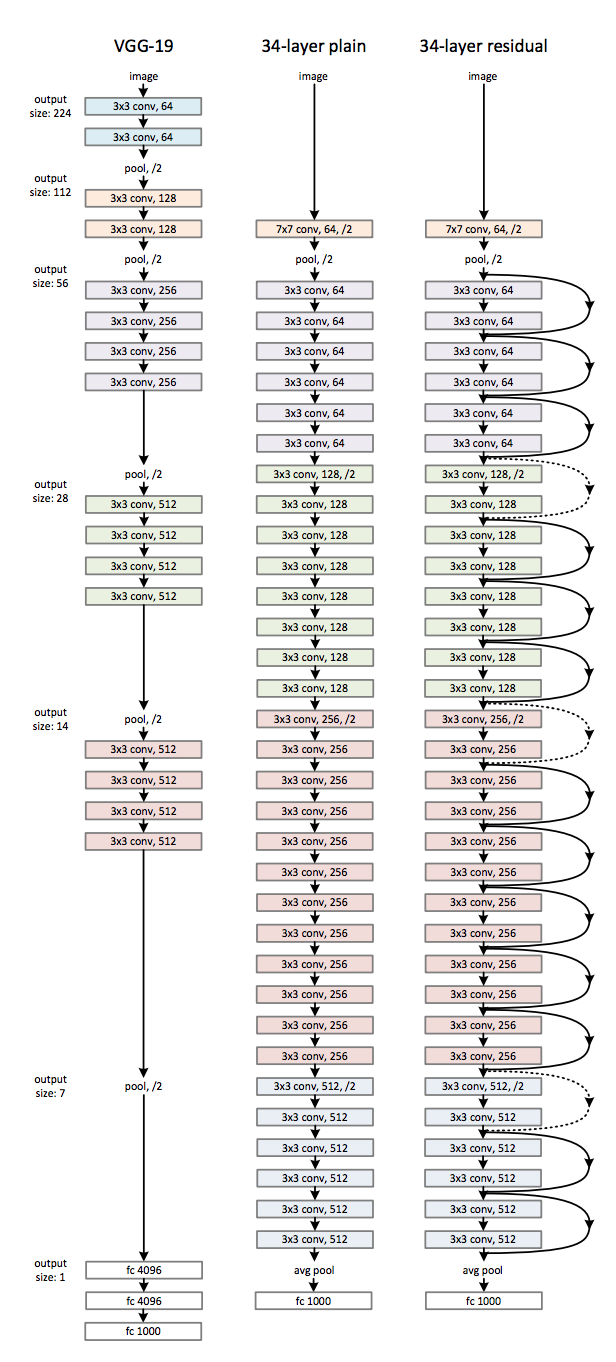





In short after a sequence of convolution layers and residual connections, the classification is done by a single fully connected layer after average pooling of spatial features.

Let's have a look at the model.
A first way is to use the print function of PyTorch:

In [ ]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Another way to look at a model is to use the torchsummary lib that reproduces a keras functionnality:

In [ ]:
import torchsummary
torchsummary.summary(model_ft.to(device), input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

What is important for classification is the last layer:
>   (fc): Linear(in_features=512, out_features=1000, bias=True)


resnet18 extracts 512 features from images, then uses a linear layer with 1000 outputs for a classification (with crossentropy loss that includes the softmax layer).


### Adapting the model to our task:

We need to adapt the network to our classification with only 2 classes (bees and ants).

In [ ]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
print(model_ft.fc)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Linear(in_features=512, out_features=2, bias=True)


## Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than 2
minutes.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5023 Acc: 0.7541
val Loss: 0.2419 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4589 Acc: 0.7869
val Loss: 0.2255 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4808 Acc: 0.7910
val Loss: 0.2401 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5776 Acc: 0.7910
val Loss: 0.2051 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.6629 Acc: 0.7746
val Loss: 0.2399 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4656 Acc: 0.8279
val Loss: 0.3577 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.4902 Acc: 0.7992
val Loss: 0.3235 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3367 Acc: 0.8852
val Loss: 0.2125 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3744 Acc: 0.8443
val Loss: 0.2337 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3676 Acc: 0.8361
val Loss: 0.2047 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2344 Acc: 0.8852
val Loss: 0.2229 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2902 Acc: 0.9016
val Loss: 0.2014 Acc: 0.9150

Ep

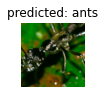

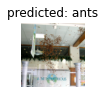

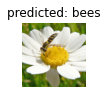

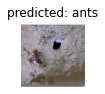

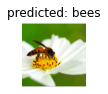

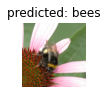

In [ ]:
visualize_model(model_ft)

# Pretrained ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9114 Acc: 0.5943
val Loss: 0.2035 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4276 Acc: 0.8197
val Loss: 0.2052 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3478 Acc: 0.8361
val Loss: 0.2587 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.6121 Acc: 0.7746
val Loss: 0.7335 Acc: 0.7516

Epoch 4/24
----------
train Loss: 0.4411 Acc: 0.8238
val Loss: 0.1609 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.6699 Acc: 0.7623
val Loss: 0.2098 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.5002 Acc: 0.8074
val Loss: 0.1750 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3503 Acc: 0.8197
val Loss: 0.1669 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2895 Acc: 0.8852
val Loss: 0.1996 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3834 Acc: 0.8320
val Loss: 0.2311 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3168 Acc: 0.8607
val Loss: 0.1819 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4103 Acc: 0.8156
val Loss: 0.1679 Acc: 0.9542

Ep

In [ ]:
visualize_model(model_conv)

#Exercise 1: Discussion

1. Explain how the model given by the train function is selected.
2. What is missing here to assess the performance of this model (output of train function)?

1.Expliquement rapidement ce que fait la fonctrion train_model et surtout quelle est la sortie de la fonction?

#Exercise 2: Apply the same approach to VGG-19

In this exercice we will use the pretrained VGG19 model as a fixed feature extractor. However the classifier part of VGG19 is more complex than the one of Resnet18.


1. Adapt and retrain the last linear layer of the classifier part of the VGG19 model (see above cell).
2. Adapt the last layer and retrain all the parameters  of the VGG19 model(fine tunning of all parameters)
3. Compare the results of both approaches.


In [ ]:
model_conv = torchvision.models.vgg19(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Send the model to GPU
model_conv = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

params_to_update = model_conv.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_conv.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_conv.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3923 Acc: 0.8361
val Loss: 0.2425 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3629 Acc: 0.8238
val Loss: 0.2181 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3883 Acc: 0.8607
val Loss: 0.2395 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3577 Acc: 0.8689
val Loss: 0.2161 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3559 Acc: 0.8361
val Loss: 0.2454 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3795 Acc: 0.8033
val Loss: 0.2466 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.2881 Acc: 0.8852
val Loss: 0.2221 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2771 Acc: 0.8770
val Loss: 0.2341 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3481 Acc: 0.8484
val Loss: 0.2516 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3455 Acc: 0.8689
val Loss: 0.2413 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3718 Acc: 0.8402
val Loss: 0.2492 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4346 Acc: 0.7992
val Loss: 0.2292 Acc: 0.9281

Ep

#Exercice 3: Classification of another dataset

In this exercise you will classify pictures of flowers.
First we describe the dataset and provide functions for loading the dataset in compatible form for PyTorch.

The exercise really begins once the dataloaders are defined.


### A little perspective:
Quoting the research work related to the database:

> *Automated Flower Classification over a Large Number of Classes*,
M. Nilsback, A. Zisserman,
Indian Conference on Computer Vision, Graphics and Image Processing, Dec 2008

https://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/

> Finally, using the features computed in this paper and the multiple kernel classifier leads to a performance of 88.33±0.3%. This is the best performance todate reported on the 17 class flower dataset.

You should get a better performance using off-the-shelf deep neural networks for image classification.
This shows once again the performance gain that deep neural networks allow for.


## 17 Category Flower Dataset
Dataset description:

 * Source: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html
 * 17 classes, 80 images per classes (total: 17*80 = 1360 images)
 * Images 1 to 80 are class 0, 81 to 160 are class 1 etc...
 * Classes in the image file order are

        classes = ['Daffodil','Snowdrop', 'Lily_Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts_Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']
 * 3 different train / val / test data splits are given by the authors in ```datasplits.mat```.

In [ ]:
# get data:
!wget -c https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
!wget -c https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat
!tar zxf 17flowers.tgz
!ls
# should have a jpg/ folder

--2023-02-01 13:08:38--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  94.6MB/s    in 0.6s    

2023-02-01 13:08:39 (94.6 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]

--2023-02-01 13:08:39--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7487 (7.3K)
Saving to: ‘datasplits.mat’

datasplits.mat      100%[===================>]   7.31K  --.-KB/s    in 0s      

2023-02-01 13:08:39 (119 MB/s) - ‘datasplits.mat’ saved [7487

In [ ]:
import scipy.io
ds = scipy.io.loadmat('datasplits.mat')
print(ds.keys())
#print(ds['trn1'])
print('total images for split 1: ', ds['trn1'].size + ds['tst1'].size + ds['val1'].size)

classes = ['Daffodil','Snowdrop', 'Lily_Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts_Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

dict_keys(['__header__', '__version__', '__globals__', 'trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1'])
total images for split 1:  1360


## Visualize one image per class from the dataset:

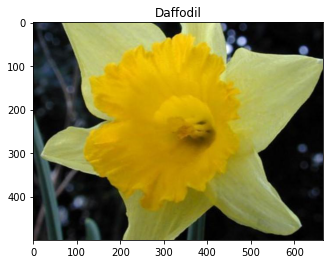

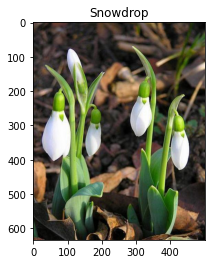

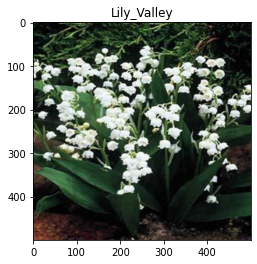

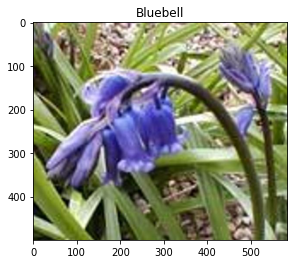

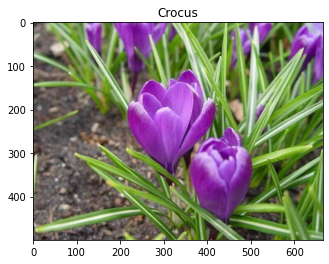

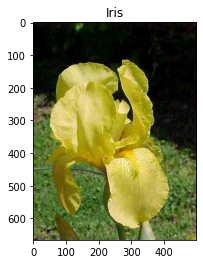

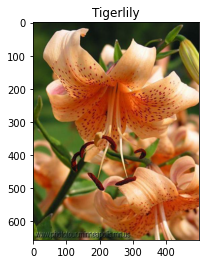

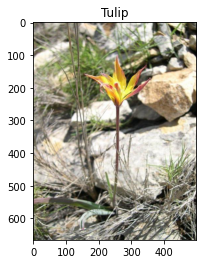

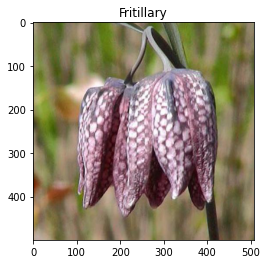

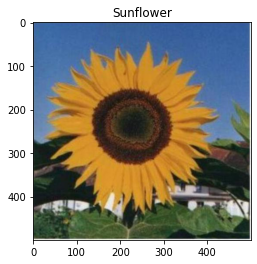

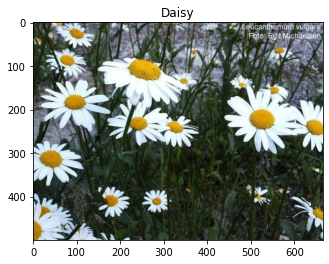

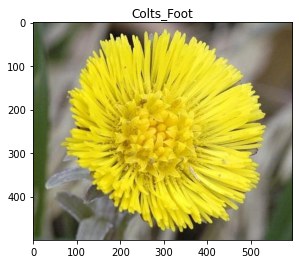

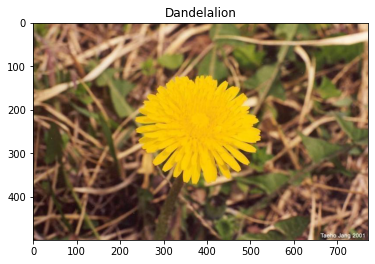

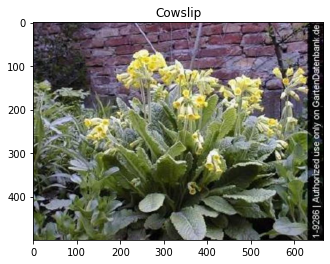

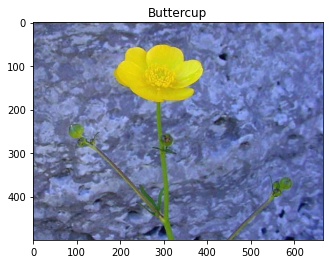

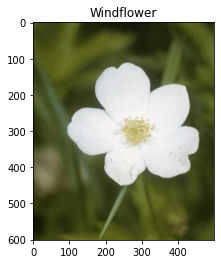

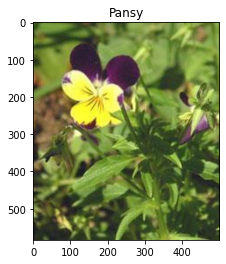

In [ ]:
import imageio

for i in range(17):
  plt.imshow(imageio.imread('jpg/image_'+str(80*i+1+np.random.randint(80)).zfill(4)+'.jpg'))
  plt.title(classes[i])
  plt.show()

## Create generic dataset structure for torchvision.datasets.ImageFolder

Quoting the documentation for [```torchvision.datasets.ImageFolder```](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder):

> A generic data loader where the images are arranged in this way:
  ```
   root/dog/xxx.png
   root/dog/xxy.png
   root/dog/xxz.png
   ...
   root/cat/123.png
   root/cat/nsdf3.png
   root/cat/asd932_.png
   ```

In [ ]:
# create folder structure for torchvision.datasets.ImageFolder
rootdir = 'flowers17'
os.makedirs(rootdir, exist_ok=True)
phases = ['train', 'test', 'val']
datadirs = [os.path.join(rootdir, x) for x in phases]
print(datadirs)
for dir in datadirs:
  os.makedirs(dir, exist_ok=True)
  for cl in classes:
    os.makedirs(os.path.join(dir,cl), exist_ok=True)

# go through the train/val/test splitting #1 of the database and copy image files:
imgnumbers = [ds['trn1'].ravel(), ds['tst1'].ravel(), ds['val1'].ravel()]
#print(imgnumbers)

for i, imgnb in enumerate(imgnumbers):
  for j in imgnb:
    fpath = 'jpg/image_'+str(j).zfill(4)+'.jpg'
    cl = (j-1)//80
    destdir = os.path.join(rootdir, phases[i], classes[cl])+'/'
    os.system('cp '+fpath+' '+destdir)

['flowers17/train', 'flowers17/test', 'flowers17/val']


## Back to PyTorch:

In [ ]:
from IPython.testing import test
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_transforms['test'] = data_transforms['val']

data_dir = rootdir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print('Class names are: ', class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Class names are:  ['Bluebell', 'Buttercup', 'Colts_Foot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelalion', 'Fritillary', 'Iris', 'Lily_Valley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'Tulip', 'Windflower']


In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize (pour avoir des images entre 0 et 1 et pas des images negatives)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #reciproque de la fct transform
    plt.show()

imshow(out, title= [class_names[x] for x in classes] )

TypeError: ignored

## ResNet18 as a flower classifier

## Exercise 3:
1. Adapt the methodology of the section 'Pretrained ConvNet as fixed feature extractor' to use ResNet18 for the classification of this flower dataset.
2. Use the unseen 'test' images to evaluate the retained "best" trained model. Report the performance using metrics from scikit-learn with:



```
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
```


3. Perform fine-tuning of the full resnet18 network and compare the performances of both adapted networks.


## Pretrained ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 17)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.1193 Acc: 0.7000
val Loss: 0.4217 Acc: 0.9059

Epoch 1/24
----------
train Loss: 0.9710 Acc: 0.7471
val Loss: 0.3539 Acc: 0.9088

Epoch 2/24
----------
train Loss: 0.8661 Acc: 0.7691
val Loss: 0.3575 Acc: 0.9088

Epoch 3/24
----------
train Loss: 0.8291 Acc: 0.7853
val Loss: 0.3728 Acc: 0.8853

Epoch 4/24
----------
train Loss: 0.7957 Acc: 0.7735
val Loss: 0.2888 Acc: 0.9088

Epoch 5/24
----------
train Loss: 0.6731 Acc: 0.8235
val Loss: 0.2894 Acc: 0.9235

Epoch 6/24
----------
train Loss: 0.6394 Acc: 0.8279
val Loss: 0.2614 Acc: 0.9353

Epoch 7/24
----------
train Loss: 0.6524 Acc: 0.8294
val Loss: 0.2938 Acc: 0.9235

Epoch 8/24
----------
train Loss: 0.6793 Acc: 0.8132
val Loss: 0.2618 Acc: 0.9265

Epoch 9/24
----------
train Loss: 0.6566 Acc: 0.8191
val Loss: 0.2716 Acc: 0.9294

Epoch 10/24
----------
train Loss: 0.6674 Acc: 0.8044
val Loss: 0.2576 Acc: 0.9382

Epoch 11/24
----------
train Loss: 0.6731 Acc: 0.8191
val Loss: 0.2755 Acc: 0.9294

Epoch 12/24
----------
t

## Performance on test dataset, and evaluation using sklearn.metrics functions

In [ ]:
testloader=torch.utils.data.DataLoader(image_datasets['test'], batch_size=4,
                                             shuffle=True, num_workers=4)

# prepare to count predictions for each class (prediction par class)
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_conv(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label.to(device)]] += 1
            total_pred[class_names[label.to(device)]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy for class: Bluebell is 100.0 %
Accuracy for class: Buttercup is 95.0 %
Accuracy for class: Colts_Foot is 95.0 %
Accuracy for class: Cowslip is 90.0 %
Accuracy for class: Crocus is 95.0 %
Accuracy for class: Daffodil is 85.0 %
Accuracy for class: Daisy is 100.0 %
Accuracy for class: Dandelalion is 90.0 %
Accuracy for class: Fritillary is 90.0 %
Accuracy for class: Iris  is 85.0 %
Accuracy for class: Lily_Valley is 80.0 %
Accuracy for class: Pansy is 100.0 %
Accuracy for class: Snowdrop is 90.0 %
Accuracy for class: Sunflower is 100.0 %
Accuracy for class: Tigerlily is 100.0 %
Accuracy for class: Tulip is 90.0 %
Accuracy for class: Windflower is 95.0 %


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

correct=0
total=0
allabels=torch.tensor([])
allpred=torch.tensor([])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        allabels=torch.cat([allabels,labels])
        outputs = model_conv(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        allpred=torch.cat([allpred.to(device),predicted])
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the test images : {100*correct//total} %')


Accuracy of the network on the test images : 92 %


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        20
         1.0       0.95      0.95      0.95        20
         2.0       0.95      0.95      0.95        20
         3.0       0.86      0.90      0.88        20
         4.0       0.90      0.95      0.93        20
         5.0       0.85      0.85      0.85        20
         6.0       1.00      1.00      1.00        20
         7.0       0.95      0.90      0.92        20
         8.0       1.00      0.90      0.95        20
         9.0       0.89      0.85      0.87        20
        10.0       0.94      0.80      0.86        20
        11.0       1.00      1.00      1.00        20
        12.0       0.86      0.90      0.88        20
        13.0       1.00      1.00      1.00        20
        14.0       0.95      1.00      0.98        20
        15.0       0.82      0.90      0.86        20
        16.0       0.95      0.95      0.95        20

    accuracy              

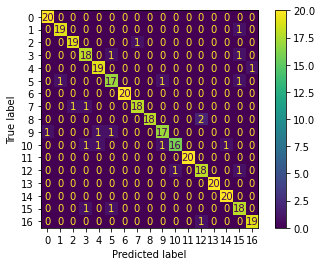

In [ ]:
CM=confusion_matrix(allabels.cpu().numpy(), allpred.cpu().numpy())   #crée une matrice de confusion...

print(classification_report(allabels.numpy(),allpred.cpu().numpy()))  #résumé pour voir en %tage la precision (accuracy)

display=ConfusionMatrixDisplay(CM)
display.plot()


In [ ]:
class_names

['Bluebell',
 'Buttercup',
 'Colts_Foot',
 'Cowslip',
 'Crocus',
 'Daffodil',
 'Daisy',
 'Dandelalion',
 'Fritillary',
 'Iris',
 'Lily_Valley',
 'Pansy',
 'Snowdrop',
 'Sunflower',
 'Tigerlily',
 'Tulip',
 'Windflower']

## Comparison with fine-tuning of full network

In [ ]:
#TODO